Project: Astro
==============

This project uses the astrophysical phenomena of Strong Gravitational Lensing to illustrate topological model
composition and fitting with **PyAutoFit**.

A strong gravitational lens is a system where two (or more) galaxies align perfectly down our line of sight from Earth
such that the foreground galaxy's mass deflects the light of a background source galaxy(s).

When the alignment is just right and the lens is massive enough, the background source galaxy appears multiple
times. The schematic below shows such a system, where light-rays from the source are deflected around the lens galaxy
to the observer following multiple distinct paths.

![Schematic of Gravitational Lensing](https://raw.githubusercontent.com/Jammy2211/PyAutoLens/master/docs/overview/images/lensing/schematic.jpg)
**Credit: F. Courbin, S. G. Djorgovski, G. Meylan, et al., Caltech / EPFL / WMKO**
https://www.astro.caltech.edu/~george/qsolens/

As an observer, we don't see the source's true appearance (e.g. as the red round blob of light). Instead, we only
observe its light after it has been deflected and lensed by the foreground galaxies (e.g. as the two distinct
red multiple images in the image on the left). We will of course also see the emission of the foreground
galaxy (in blue).

You can read more about gravitational lensing as the following link:

https://en.wikipedia.org/wiki/Gravitational_lens

Strong gravitational lensing is the original science case that sparked the development of **PyAutoFit**, which is
a spin off of our astronomy software PyAutoLens `https://github.com/Jammy2211/PyAutoLens`.

__PyAutoFit__

Strong lensing is a great case study for using **PyAutoFit**, due to the multi-component nature of how one composes
a strong lens model. To model a strong lens, one needs to model the light and mass of each galaxy in the system,
where each galaxy is a model in itself, and the galaxies are combined into one overall lens model.

This example project uses **PyAutoFit** to compose and fit models of a strong lens, in particular highlighting
**PyAutoFits** topological model composition. I recommend you check out the following description of this feature on
our readthedocs first, which uses this strong lensing example to give a high-level overview of topological models:

 https://pyautofit.readthedocs.io/en/latest/overview/topological.html

__Strong Lens Modeling__

The models are fitted to Hubble Space Telescope imaging of a real strong lens system and will allow us to come up
with a description of how light is deflected on its path through he Universe.

This project consists of two example scripts / notebooks:

 1) `example_1_intro`: An introduction to strong lensing, and the various parts of the project's source code that are
 used to represent a strong lens galaxy.

 2) `example_2_topological model`: Using **PyAutoFit** to model a strong lens, with a strong emphasis on the
 topological model API.

__This Example__

This introduction primarily focused on what strong lensing is, how we define the individual model-components and fit
a strong lens model to data. It does not make much use of **PyAutoFit**, but it does provide a clear understanding of
the model so that **PyAutoFit**'s use in example 2 is clear.

In [2]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import src as astro
import matplotlib.pyplot as plt
import numpy as np
from os import path

C:\Users\Jammy\Code\PyAuto\autofit_skies
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\autofit_skies`


__Plot__

We will plot a lot of arrays of 2D data and grids of 2D coordinates in this example, so lets make a convenience 
functions.

In [3]:
def plot_array(array, title=None, norm=None):

    plt.imshow(array, norm=norm)
    plt.colorbar()
    plt.title(title)
    plt.show()
    plt.close()

def plot_grid(grid, title=None):

    plt.scatter(x=grid[:, :, 0], y=grid[:, :, 1], s=1)
    plt.title(title)
    plt.show()
    plt.close()

__Data__

First, lets load and plot Hubble Space Telescope imaging data of the strong gravitational lens called SDSSJ2303+1422, 
where this data includes:
 
 1) The image of the strong lens, which is the data we'll fit.
 2) The noise in every pixel of this image, which will be used when evaluating the likelihood.

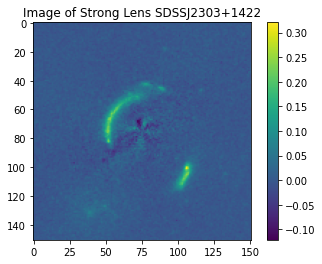

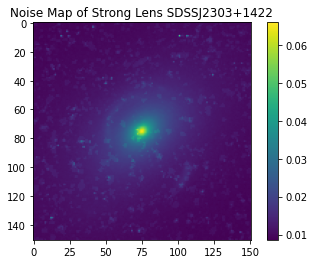

In [5]:
dataset_path = path.join("dataset", "slacs2303+1422")

image = np.load(file=path.join(dataset_path, "image.npy"))
noise_map = np.load(file=path.join(dataset_path, "noise_map.npy"))

plot_array(array=image, title="Image of Strong Lens SDSSJ2303+1422")
plot_array(array=noise_map, title="Noise Map of Strong Lens SDSSJ2303+1422")

In the image of the strong lens two distinct objects can be seen:

 1) A central blob of light, corresponding to the foreground lens galaxy whose mass is responsible for deflecting light.
 2) A surrounding ring of light, which is the lensed background source.
 
__Grid__
 
To perform strong lensing, we need a grid of (x,y) coordinates which we map throughout the Universe as if their path
is deflected. For this, we create a simple 2D grid of coordinates below where the origin is (0.0, 0.0) and the size of
a pixel is 0.05, which corresponds to the resolution of our `image`.

(The grid below is created using the python script `astro/dataset/grid.py` and is simply a uniform 2D grid of
coordinates).

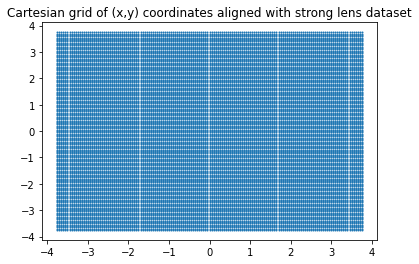

In [6]:
grid = np.load(file=path.join(dataset_path, "grid.npy"))

plot_grid(grid=grid, title="Cartesian grid of (x,y) coordinates aligned with strong lens dataset")

__Light Profiles__

Our model of a strong lens must include a description of the light of each galaxy, which we call a 'light profile'.
In the source-code of this example project, specifically the module `astro/src/light_profiles.py` you will see there
are two light profile classes named `LightDeVaucouleurs` and `LightExponential`.

These Python classes are the model components we will use to represent each galaxy's light and they behave analogous 
to the `Gaussian` class seen in other tutorials. The input parameters of their `__init__` constructor (e.g. centre, 
axis_ratio, angle) are their model parameters that may be fitted for by a non-linear search.

These classes also contain functions which create an image from the light profile if an input grid of (x,y) 2D 
coordinates are input, which we use below to create an image of a light profile.

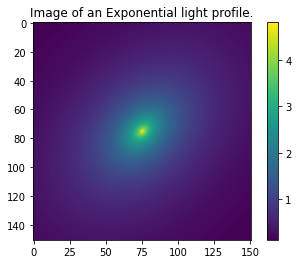

In [7]:
light_profile = astro.lp.LightExponential(
    centre=(0.01, 0.01), axis_ratio=0.7, angle=45.0, intensity=1.0, radius=2.0
)
light_image = light_profile.image_from_grid(grid=grid)

plot_array(array=light_image, title="Image of an Exponential light profile.")

__Mass Profiles__

Our model also includes the mass of the foreground lens galaxy, called a 'mass profile'. In the source-code of the 
example project, specifically the module `astro/src/mass_profiles.py` you will see there is a mass profile class named 
`MassIsothermal`. Like the light profile, this will be a model-component **PyAutoFit** fits via a non-linear search.

The class also contain a functions which create the 'deflections', which describes the angle that light is deflected by
in the x and y components of its coordinates. A higher mass galaxy, which bends light more, will have higher values
of the deflection angles plotted below:

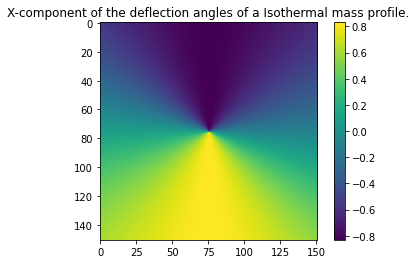

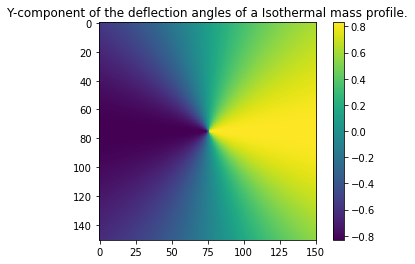

In [8]:
mass_profile = astro.mp.MassIsothermal(
    centre=(0.01, 0.01), axis_ratio=0.7, angle=45.0, mass=0.5
)
mass_deflections = mass_profile.deflections_from_grid(grid=grid)

plot_array(array=mass_deflections[:, :, 0], title="X-component of the deflection angles of a Isothermal mass profile.")
plot_array(array=mass_deflections[:, :, 1], title="Y-component of the deflection angles of a Isothermal mass profile.")

__Ray Tracing__

The deflection angles describe how our (x,y) grid of coordinates are deflected by the mass of the foreground galaxy.
We can therefore ray-trace the grid aligned with SDSSJ2303+1422 using the mass profile above and plot a grid of
coordinates in the reference frame of before their light is gravitationally lensed:

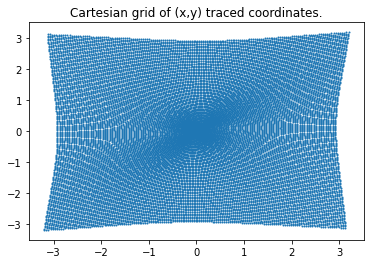

In [9]:
traced_grid = grid - mass_deflections

plot_grid(grid=traced_grid, title="Cartesian grid of (x,y) traced coordinates.")

By inputting this traced grid of (x,y) coordinates into our light profile, we can create an image of the galaxy as if
it were gravitationally lensed by the mass profile.

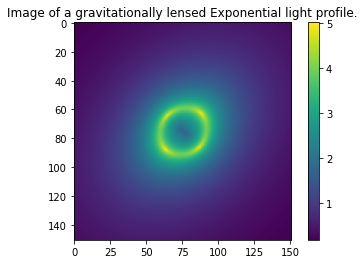

In [10]:
traced_light_image = light_profile.image_from_grid(grid=traced_grid)

plot_array(array=traced_light_image, title="Image of a gravitationally lensed Exponential light profile.")

__Galaxy__

In the `src/galaxy.py` module we define the `Galaxy` class, which is a collection of light and mass profiles at an 
input redshift. For strong lens modeling, we have to use `Galaxy` objects, as the redshifts define how ray-tracing is
performed.

Below, we create two instances of the `Galaxy` class, representing the lens and source galaxies in a strong lens system.

In [11]:
light_profile = astro.lp.LightDeVaucouleurs(
    centre=(0.01, 0.01), axis_ratio=0.9, angle=45.0, intensity=0.1, radius=1.0
)
mass_profile = astro.mp.MassIsothermal(
    centre=(0.01, 0.01), axis_ratio=0.7, angle=45.0, mass=0.8
)
lens_galaxy = astro.Galaxy(redshift=0.5, light_profiles=[light_profile], mass_profiles=[mass_profile])

light_profile = astro.lp.LightExponential(
    centre=(0.1, 0.1), axis_ratio=0.5, angle=80.0, intensity=1.0, radius=5.0
)
source_galaxy = astro.Galaxy(
    redshift=0.5, light_profiles=[light_profile], mass_profiles=[mass_profile])

A galaxy's image is the sum of its light profile images, and its deflection angles are the sum of its mass profile
deflection angles.

To illustrate this, lets plot the lens galaxy's light profile image:

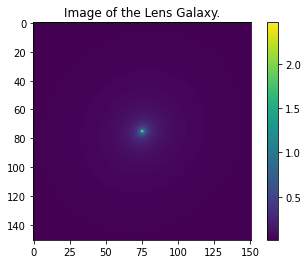

In [12]:
galaxy_image = lens_galaxy.image_from_grid(grid=grid)

plot_array(array=galaxy_image, title="Image of the Lens Galaxy.")

__Data Fitting__

We can create an overall image of the strong lens by:

 1) Creating an image of the lens galaxy.
 2) Computing the deflection angles of the lens galaxy.
 3) Ray-tracing light to the source galaxy reference frame and using its light profile to make its image.

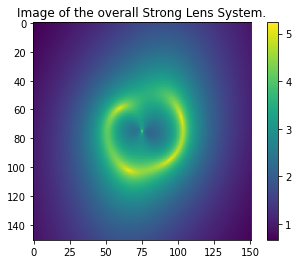

In [13]:
lens_image = lens_galaxy.image_from_grid(grid=grid)
lens_deflections = lens_galaxy.deflections_from_grid(grid=grid)

traced_grid = grid - lens_deflections

source_image = source_galaxy.image_from_grid(grid=traced_grid)

model_image = lens_image + source_image

plot_array(array=model_image, title="Image of the overall Strong Lens System.")

By subtracing this model image from the data, we can create a 2D residual map. This is equivalent to the residual maps
we made in the 1D Gaussian examples, except for 2D imaging data.

Clearly, the random lens model we used in this example does not provide a good fit to SDSSJ2303+1422.

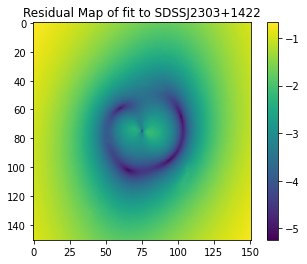

In [14]:
residual_map = image - model_image

plot_array(array=residual_map, title="Residual Map of fit to SDSSJ2303+1422")

Just like we did for the 1D `Gaussian` fitting examples, we can use the noise-map to compute the normalized residuals 
and chi-squared map of the lens model.

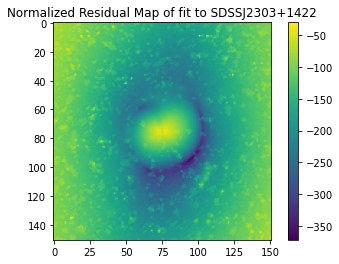

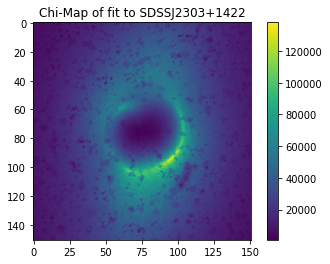

In [15]:
normalized_residual_map = residual_map / noise_map
chi_squared_map = (normalized_residual_map) ** 2.0

plot_array(array=normalized_residual_map, title="Normalized Residual Map of fit to SDSSJ2303+1422")
plot_array(array=chi_squared_map, title="Chi-Map of fit to SDSSJ2303+1422")

Finally, we can compute the likelihood of this lens model, which we will use in the next example to fit the lens model 
to data with a non-linear search.

In [16]:
chi_squared = np.sum(chi_squared_map)
noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))

log_likelihood = -0.5 * (chi_squared + noise_normalization)

print(log_likelihood)

-320164397.733175


__Wrap Up__

In this example, we introduced the astrophysical phenomena of strong gravitational lensing, and gave an overview of how
one can create a model for a strong lens system and fit it to imaging data. 

We ended by defining the log likelihood of the model-fit, which will form the `log_likelihood_function` of the
`Analysis` class we use in the next example, which fits this strong lens using **PyAutoFit**.

There is one thing you should think about, how would we translate the above classes (e.g. `LightExponential`, 
`MassIsothermal` and `Galaxy`) using the **PyAutoFit** `Model` and `Collection` objects? The `Galaxy` class contained 
instances of the light and mass profile classes, meaning the standard use of the `Model` and `Collection` objects could 
not handle this.

This is where topological models come in, as will be shown in the next example!